# State Memory
As a graph executes, a snapshot of each state is stored in memory. A snapshot includes the agent state we have already defined, along with other useful information such as the thread and a unique identifier for each snapshot.

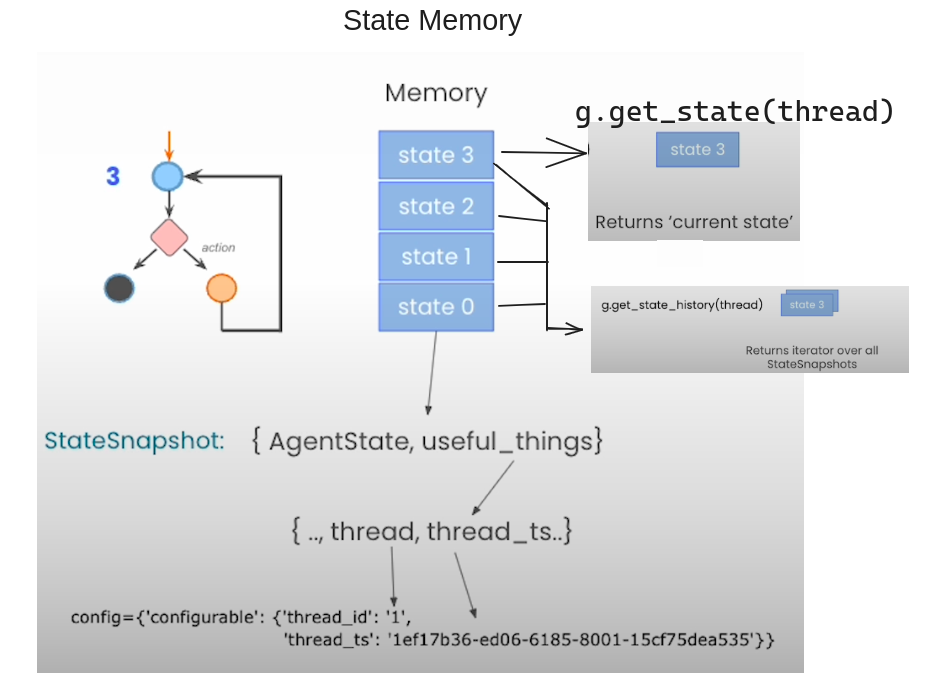

We can use invoke command to access any state and use that as current state using `thread_ts` the unique identifier
```python
g.invoke(None, {..., thread, thread_ts..})
g,strean(None, {..., thread, thread_ts..})
```

## Human in the Loop

In [1]:
import operator
from uuid import uuid4
from typing import TypedDict, Annotated

from langgraph.graph import StateGraph, END

from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    ToolMessage
)
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
from IPython.display import Image

# load dotenv
load_dotenv()

True

In [2]:
# initialize the tool
tool = TavilySearchResults(max_results=2)

# initialize the memory for saving state
memory = MemorySaver()

In [3]:
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign id to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged  = left.copy()
    for message  in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

### Manual Human Approval
We have added the `interrupt_before` parameter to the `graph.compile` method, which introduces an interrupt before calling the action node. This ensures that actions requiring manual approval are performed correctly.

LangGraph also supports interruptions when calling specific tools only. For more details, refer to the [documentation](https://langchain-ai.github.io/langgraph/reference/prebuilt/).

In [5]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action,
                                        {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer,
                                    interrupt_before=["action"])
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(tool_call_id=t["id"],
                                        name=t["name"],
                                        content=str(result)))
        print("Back to the model!")
        return {"messages": results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

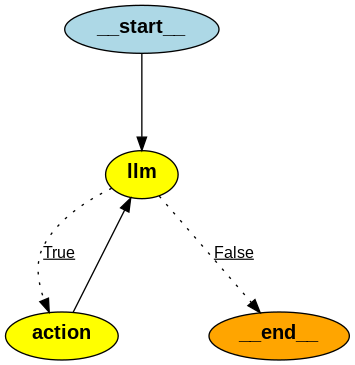

In [7]:
Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="Whats the weather inn SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(f">>> \033[95m{v} \033[0m")

{'messages': [HumanMessage(content='Whats the weather inn SF?', additional_kwargs={}, response_metadata={}, id='0e468cd2-3853-4fee-b94a-15bfeda159b0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZvvtIHsKhvABdW5nFw1mQfzc', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f406f67-ca0d-4161-bb9f-b6e807dbe559-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ZvvtIHsKhvABdW5nFw1mQfzc'

In [9]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather inn SF?', additional_kwargs={}, response_metadata={}, id='0e468cd2-3853-4fee-b94a-15bfeda159b0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZvvtIHsKhvABdW5nFw1mQfzc', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f406f67-ca0d-4161-bb9f-b6e807dbe559-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Zvvt

In [10]:
abot.graph.get_state(thread).next

('action',)

### Continue after interrupt
Here, the graph execute the tools and then calls the LLM after that. Since there is no any interrupt defined when going from actions to LLM.

In [11]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(f">>> \033[95m{v} \033[0m")

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ZvvtIHsKhvABdW5nFw1mQfzc', 'type': 'tool_call'}
Back to the model!
>>> {'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1735723005, \'localtime\': \'2025-01-01 01:16\'}, \'current\': {\'last_updated_epoch\': 1735722900, \'last_updated\': \'2025-01-01 01:15\', \'temp_c\': 7.2, \'temp_f\': 45.0, \'is_day\': 0, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/116.png\', \'code\': 1003}, \'wind_mph\': 4.3, \'wind_kph\': 6.8, \'wind_degree\': 287, \'wind_dir\': \'WNW\', \'pressure_mb\': 1023.0, \'pressure_in\': 30.21, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 71, \'cloud\': 25

In [12]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather inn SF?', additional_kwargs={}, response_metadata={}, id='0e468cd2-3853-4fee-b94a-15bfeda159b0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZvvtIHsKhvABdW5nFw1mQfzc', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5f406f67-ca0d-4161-bb9f-b6e807dbe559-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Zvvt

In [13]:
# the execution has ended. So it returns empty for next state
abot.graph.get_state(thread).next

()

### New Message thread

In [14]:
messages = [HumanMessage("Whats the weather in LA?")]

thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(f">>> \033[95m{v} \033[0m")

while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread), "\n")
    _input = input("proceed(y)?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(f">>> \033[95m{v} \033[0m")

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='459e7124-0419-4902-8708-79862775b0c0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cPUS3cDyAN8uHCEchpAmjfM9', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cf57084a-69b3-4f81-bac8-883d75d53d40-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_cPUS3cDyAN8uHCEchpAmjfM9', 'ty

proceed(y)? y


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_cPUS3cDyAN8uHCEchpAmjfM9', 'type': 'tool_call'}
Back to the model!
>>> {'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1735723046, \'localtime\': \'2025-01-01 01:17\'}, \'current\': {\'last_updated_epoch\': 1735722900, \'last_updated\': \'2025-01-01 01:15\', \'temp_c\': 12.2, \'temp_f\': 54.0, \'is_day\': 0, \'condition\': {\'text\': \'Mist\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/143.png\', \'code\': 1030}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 345, \'wind_dir\': \'NNW\', \'pressure_mb\': 1018.0, \'pressure_in\': 30.07, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 90, \'cloud\': 100, \'feelsl

proceed? n


aborting


### Modify State

Run until the interrupt and then modify the state.

In [15]:
messages = [HumanMessage("Whats the weather in LA?")]

thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(f">>> \033[95m{v} \033[0m")

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'ty

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu

In [17]:
current_values = abot.graph.get_state(thread)

In [18]:
current_values.values["messages"][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 22, 'total_tokens': 174, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [19]:
current_values.values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS',
  'type': 'tool_call'}]

In [20]:
_id = current_values.values["messages"][-1].tool_calls[0]["id"]
current_values.values["messages"][-1].tool_calls = [
    {"name": "tavily_search_results_json",
     "args": {"query": "current weather in Louisiana"},
     "id": _id}
]

In [21]:
# update the state by replacing what to call in tool
# instead of current weather in LA, call current weather in Louisiana
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc8214-8e71-6407-8002-0139ad0b62c5'}}

In [22]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_TaG

In [23]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(f">>> \033[95m{v} \033[0m")

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'type': 'tool_call'}
Back to the model!
>>> {'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.4411, \'lon\': -91.0551, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1735722270, \'localtime\': \'2025-01-01 03:04\'}, \'current\': {\'last_updated_epoch\': 1735722000, \'last_updated\': \'2025-01-01 03:00\', \'temp_c\': -0.3, \'temp_f\': 31.5, \'is_day\': 0, \'condition\': {\'text\': \'Overcast\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/122.png\', \'code\': 1009}, \'wind_mph\': 10.1, \'wind_kph\': 16.2, \'wind_degree\': 287, \'wind_dir\': \'WNW\', \'pressure_mb\': 1023.0, \'pressure_in\': 30.2, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 76, \'cloud\': 100, \'

### Time Travel
We can use the state from histroy to initialize it as current state and proceed from that point in the graph. 

In [26]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state.values)
    print('----')
    states.append(state)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS

In [27]:
# fetch the fist data
to_replay = states[-3]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu

In [28]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(f">>> \033[95m{v['messages'][0].content} \033[0m")

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'type': 'tool_call'}
Back to the model!
>>> [{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Los Angeles', 'region': 'California', 'country': 'United States of America', 'lat': 34.0522, 'lon': -118.2428, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1735723046, 'localtime': '2025-01-01 01:17'}, 'current': {'last_updated_epoch': 1735722900, 'last_updated': '2025-01-01 01:15', 'temp_c': 12.2, 'temp_f': 54.0, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 345, 'wind_dir': 'NNW', 'pressure_mb': 1018.0, 'pressure_in': 30.07, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 90, 'cloud': 100, 'feelslike_c': 12.7, 'feelslike_f': 54.8, 'windchill_c': 12.8, 'windchill_f': 55.1, 'heatindex_c': 13.1, 'heatindex_f': 55.6,

### Going in previous State and Edit

In [29]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu

In [30]:
_id = to_replay.values["messages"][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
      'args': {'query': 'current weather in LA, accuweather'},
      'id': _id}
]

In [31]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_TaG8CJxhu4hSi1Bckd

In [32]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(f">>> \033[95m{v['messages'][0].content} \033[0m")

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'type': 'tool_call'}
Back to the model!
>>> [{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Los Angeles', 'region': 'California', 'country': 'United States of America', 'lat': 34.0522, 'lon': -118.2428, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1735723046, 'localtime': '2025-01-01 01:17'}, 'current': {'last_updated_epoch': 1735722900, 'last_updated': '2025-01-01 01:15', 'temp_c': 12.2, 'temp_f': 54.0, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 345, 'wind_dir': 'NNW', 'pressure_mb': 1018.0, 'pressure_in': 30.07, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 90, 'cloud': 100, 'feelslike_c': 12.7, 'feelslike_f': 54.8, 'windchill_c': 12.8, 'windchill_f': 55.1, 'heatindex_c': 13.1, 'heatind

### Add message to a state at a given time

In [33]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'ca

#### Updating the message manually rather than calling tools

In [34]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

state_update = {
    "messages": [
        ToolMessage(
            tool_call_id=_id,
            name="tavily_search_results_json",
            content="54 degree celcius",
        )
    ]
}

In [35]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [36]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(f">>> \033[95m{v['messages'][0].content} \033[0m")

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='5c8430e1-61da-469d-bea3-3fc6305aef61'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f020e77-5591-40fc-8639-2353e3e980cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaG8CJxhu4hSi1Bckd3YkpbS', 'ty